In [1]:
# NOTE: this notebook needs to be run from the root project directory

# PREPROCESSING
from data.reddy_data.reddy_dataset import ReddyDataset, DLBCLSubtypes
# FILTERING
from src.dim_reduction.filtering import FilterPipeline
import numpy as np
# STRATIFICATION
from src.stratification.nmfcc import NMFCCRun

In [2]:
# PREPROCESSING (~45s)
reddy_dataset = ReddyDataset()
reddy_dataset.populate_all_attributes()

Reading in expression data...
Reading in clinical data...

Imputing clinical data...
How many null values in GRM to change? 22
GRM successfully imputed
How many null values in IPI to change? 152
IPI successfully imputed
How many null values in AgeAtDiagnosis to change? 31
AgeAtDiagnosis successfully imputed
How many null values in OverallSurvivalYears to change? 19
OverallSurvivalYears successfully imputed
How many null values in 'Censored'?  7
Censored values successfully imputed
We now have 775 patients with complete data.

Populating subtype attributes...
All subtype attributes populated - can now be used for visualisation.

Successfully populated all variables. You can now access the ReddyDataset patient_ids, genetic_features, expression_data, norm_expression_data, clinical_data, and subtypes.
        


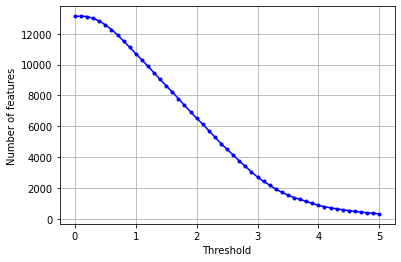


From this graph, we can see that the number of features starts decreasing linearly at a threshold of around t=0.70 as indicated by the red line and plateaus after t=3. Therefore, we make our threshold 3 to get rid of highly non-variable features (which are essentially treated as noise) which we can then perform Laplacian score filtering on.

We plot the Laplacian scores of the features using the following affinity matrix parameters: {'metric': 'cosine', 'neighbor_mode': 'knn', 'weight_mode': 'cosine', 'k': 40, 't': 500}


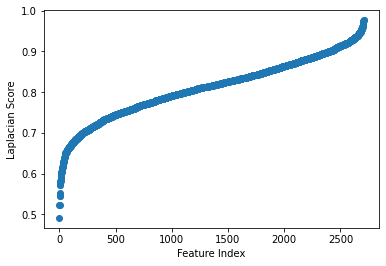


Note: in the Laplacian score we are looking for the smallest features. In a similar way to the variance thresholding graph, we find the point where the graph starts increasing linearly. Unlike the variance thresholding, we use the number of features up to the point where it starts increasing linearly as opposed to when it stops. We find the number of relevant features to be 1000.

Filtering expression data with given parameters...
We perform Laplacian score filtering using the following parameters: {'metric': 'cosine', 'neighbor_mode': 'knn', 'weight_mode': 'cosine', 'k': 40, 't': 500}

The data now has 1000 features after Laplacian score filtering.
Populating output reddy data with filtered data...
Expression data filtered. Use this class' output_reddy_dataset for following clustering.


In [3]:
# FILTERING (~20s)
filtering_pipeline = FilterPipeline(reddy_dataset) 

thresholds = np.linspace(0, 5, 51)  # create thresholds from 0 to 5 with step size 0.1L
filtering_pipeline.plot_features_against_vt_threshold(thresholds)
print("\nFrom this graph, we can see that the number of features starts decreasing linearly at a threshold of around t=0.70 as indicated by the red line and plateaus after t=3. Therefore, we make our threshold 3 to get rid of highly non-variable features (which are essentially treated as noise) which we can then perform Laplacian score filtering on.\n") 
threshold = 3

filtering_pipeline.plot_ls_after_vt_filtering(threshold)
print("\nNote: in the Laplacian score we are looking for the smallest features. In a similar way to the variance thresholding graph, we find the point where the graph starts increasing linearly. Unlike the variance thresholding, we use the number of features up to the point where it starts increasing linearly as opposed to when it stops. We find the number of relevant features to be 1000.\n")
num_features = 1000

filtering_pipeline.perform_filtering(threshold, num_features)
filtered_reddy_dataset = filtering_pipeline.output_reddy_dataset

Note the different y-axes ranges.


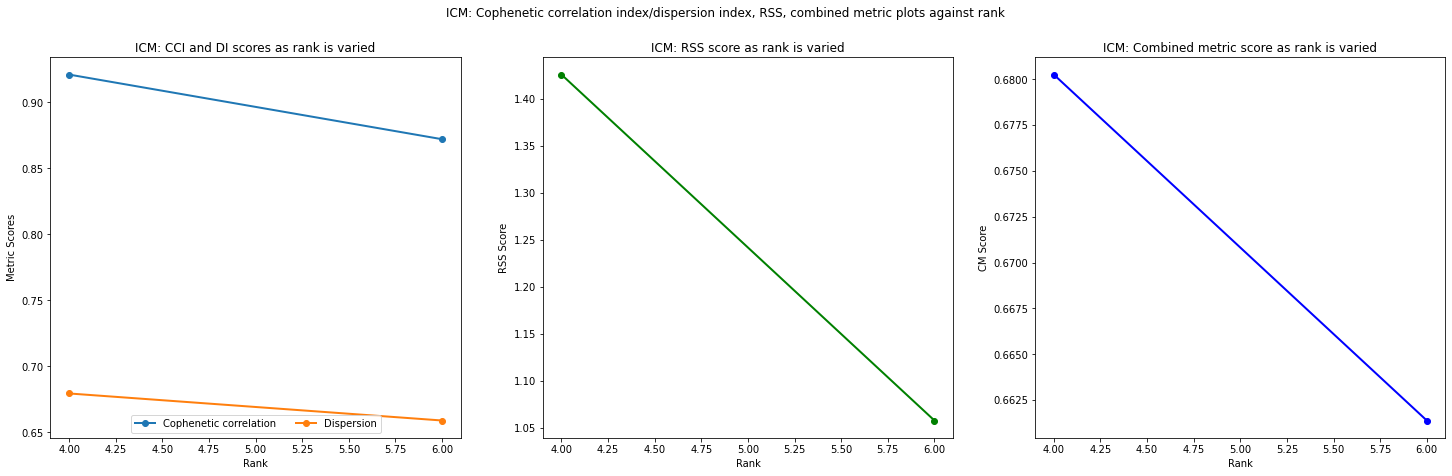

In [4]:
# STRATIFICATION

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------
### INPUT TYPES
# -----------------------------------------------------------------------------------------------------------------------------------------------------------------
# filtered_reddy_dataset = dataframe(patients on rows, genes on columns); subset_required = (num_patients, num_genes)
# ranks = [ints between 2-20] 
# nmf_method = string label. Standard NMF: "NMF", Probabilistic NMF: "PNMF", Bayesian NMF Methods: (Iterated Conditional Modes "ICM", Bayesian Decomposition "BD" )
# -----------------------------------------------------------------------------------------------------------------------------------------------------------------
### NMF METHOD HYPERPARAMETERS
# -----------------------------------------------------------------------------------------------------------------------------------------------------------------
# method_hps = {'n_runs': 5, 'alpha_bnmf': None, 'beta_bnmf': None, 'theta_bnmf': None, 'k_bnmf': None, 'sigma_bnmf': None, 'n_w': None, 'n_h': None}
# to_cluster shape: (num_genes, num_patients); alpha shape = (num_genes, self.ranks[0]); beta shape = (self.ranks[0], num_patients)
# theta = int from 0-1000 -> no more than 30 should be required; k = int from 0-15; sigma = int from 0-100
# n_w = shape (rank, 1) of Booleans -> if n_w[i] is True, column i of basis W is NOT sampled; default samples from all rows 
# n_h = shape (rank, 1) of Boolean -> if n_h[i] is True, row i of mixture H is NOT sampled; default samples from all rows
# -----------------------------------------------------------------------------------------------------------------------------------------------------------------

method_hps = {'n_runs': 5, 'alpha_bnmf': None, 'beta_bnmf': None, 'theta_bnmf': 12.5, 'k_bnmf': None, 'sigma_bnmf': None, 'n_w': None, 'n_h': None}
nmfcc_run = NMFCCRun(filtered_reddy_dataset=filtered_reddy_dataset, subset_required=(50, 100), ranks=[4, 6], nmf_method="ICM", method_hps=method_hps)
subgroups_test = nmfcc_run.create_subgroups_from_input()

We have performed hierarchical clustering on a consensus matrix and so will plot a clustermap...


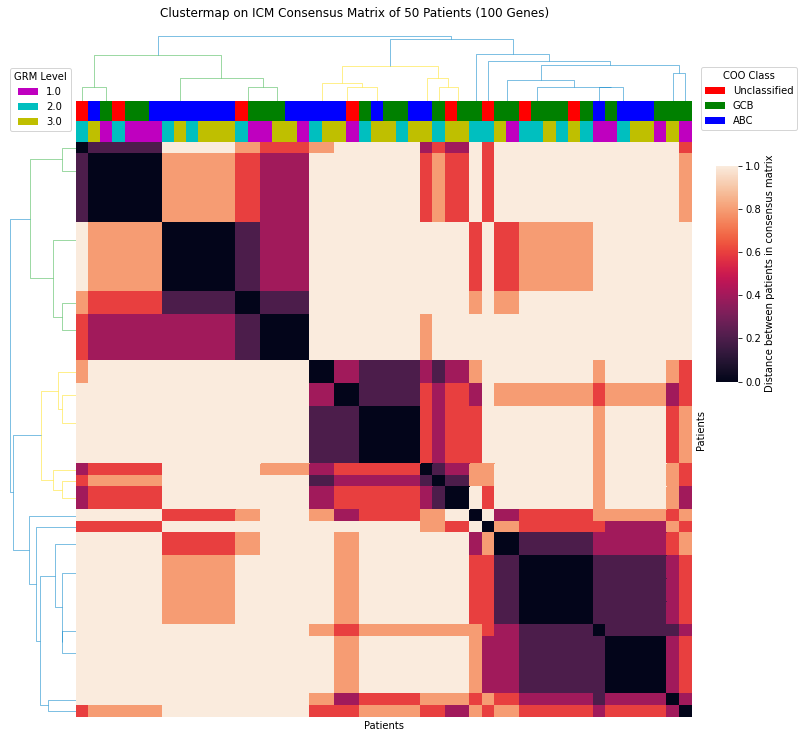

In [5]:
# VISUALISATION
nmfcc_run.visualise()